In [2]:
# CompoundCalculator - Interpretation
# 20201105 Designed to look at the output from the matching routines and  visualize/interpret them
# This is expolratory and lifted directly from the Calculator
    

In [3]:
import os
import pandas as pd
from collections import defaultdict, namedtuple
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# finds rows with the same value in the speciefied column
# returns a list of tuples - a list of the matching indices and a flag indicating if any are isotopes

def find_duplicates(df, col, flag=None, show=True):
   
    groups = df.groupby(col)
    duplicates = []
    
    for n,g in groups:
        
        if len(g) == 1: continue     #no duplicates
            
        if show: print(n, len(g),"duplicates:")
        
        these_dups = []
        has_isotope = False
        
        for i, r in g.iterrows():
            
            if flag:
                df.loc[i,'Duplicate'] = flag
            if show:
#                 print('\t',dup[0], dup[1], dup[2], dup[3],dup[4], dup[5], dup[6],dup[7], dup[8], dup[9])
                print('\t',i, r.Pk_mass, r.Pk_inten, r.Delta_mmu, r.Pk_RT, r.Pk_index, r.Mono__pk, 
                      r.Match_mass, r.Match_root, r.Match_label, r.Duplicate)
    
            these_dups.append(i)           
            has_isotope = r.Pk_index != r.Mono__pk
        
        duplicates.append((these_dups, has_isotope))
            
#     if show: print(duplicates) 
        
    return duplicates


In [5]:
def parse_item(item):
    
    result = re.match("\((.*)\)(\d+)", item)
        
    if result:
        return(result.group(1), int(result.group(2)))
    else:
        return(item,1)


def parse_labels(label_list):
    
    label_dict = {}
    
    base_parts = label_list.pop(0).split('-')   # first entry is the base compound
    
    base_name, base_count = parse_item(base_parts[0])
    
    label_dict["Base"] = base_name
    label_dict["Base_count"] = base_count
   
    if len(base_parts) > 1: 
        label_dict["Loss"] = base_parts[1]
    
    label_dict['Charge_agent'] = label_list.pop()   # last item by default
    
    for item in label_list:

        name, count = parse_item(item)       
        label_dict[name] = count
            
    return label_dict

def get_y_value(major_name,minor_name,minor_scale, loss=0):
    res = major_name + minor_name*minor_scale
    if loss:
        res = res - 0.1
    return res


In [6]:
data_path = os.sep + os.path.join('Users','ronbonner','Data', 'SharedData', 'Test')

match_file = 'S_4 MeOH FA pks 0.2 percent_DiMeSA matches.txt'

match_file_path = os.path.join(data_path, match_file)

out_path, _ = os.path.splitext(match_file_path)    # path without extension

adduct_path = f'{out_path} - adducts.csv'

print(match_file_path)

raw_df = pd.read_csv(match_file_path, sep='\t', skiprows=1 )  # skip head line

raw_df['Pk_label'] = raw_df.apply(lambda x: f'{x.Pk_mass:.4f} ({x.Pk_inten:.1e})', axis=1)

base_inten = raw_df.Pk_inten.max()

raw_df.insert(loc=2, column='Rel_inten', value = 0.0)

raw_df.Rel_inten = raw_df.Pk_inten / base_inten

print('Raw', raw_df.shape, "TIC:", raw_df.Pk_inten.sum(), "BPI:", base_inten)
raw_df.head()

/Users/ronbonner/Data/SharedData/Test/S_4 MeOH FA pks 0.2 percent_DiMeSA matches.txt
Raw (59, 11) TIC: 188252.29999999996 BPI: 107995.3


,Pk_mass,Pk_inten,Rel_inten,Delta_mmu,Pk_RT,Pk_index,Mono__pk,Match_mass,Match_root,Match_label,Pk_label
0,129.0524,3856.4,0.035709,-2.2,0.0,63,63,129.0546,DiMeSA,DiMeSA-H2O.H+,129.0524 (3.9e+03)
1,130.0551,184.0,0.001704,-0.3,0.0,65,63,130.0554,DiMeSA,129.0524(+1),130.0551 (1.8e+02)
2,131.0564,37.2,0.000344,-1.9,0.0,68,63,131.0584,DiMeSA,129.0524(+2),131.0564 (3.7e+01)
3,147.0622,1505.1,0.013937,-3.0,0.0,111,111,147.0652,DiMeSA,DiMeSA.H+,147.0622 (1.5e+03)
4,148.0657,94.3,0.000873,0.5,0.0,114,111,148.0652,DiMeSA,147.0622(+1),148.0657 (9.4e+01)


In [8]:
# Clean the data...
cleaned_df = raw_df.copy()

cleaned_df["Duplicate"] = ''

# find the duplicate peaks (same index) and determine if one or more is an isotope
# return = ([list of duplicate indices], has_isotope boolean)
pk_dups = find_duplicates(cleaned_df, "Pk_mass", flag="Peak", show=False)
print(len(pk_dups),"duplicate peaks")

# were're going to drop the duplicates retaining only the one with the smallest absolute error
# we'll aslo remove peaks where at least onematch is an isotope
drop_list = [] 

for p_list, has_isotope in pk_dups:
    
    drop_list.extend(p_list)   # add all by default
    
    if has_isotope:       #we'll remove both so no more to do...
        continue
        
    #set the last_error to some impossible value; loop to find the match with the smallest error
    last_err = 1e6
    for dup in p_list:
#         print(cleaned_df.iloc[dup,0:3])
        abs_err = abs(cleaned_df.iloc[dup,2])
        if abs_err < last_err:
            index_to_keep = dup
            last_err = abs_err
    
    # remove the index of the lowest error match from the drop list (so it's kept)
    drop_list.remove(index_to_keep)
    
#print("Drop list", len(drop_list), drop_list)

cleaned_df = cleaned_df.drop(index=drop_list)

print('After peak cleaning:',cleaned_df.shape)

# See if there are any duplicate matches - at the moment we don't remove then
match_dups = find_duplicates(cleaned_df,"Match_mass", flag="Match", show=True)
print(len(match_dups),"duplicate matches")


1 duplicate peaks
After peak cleaning: (58, 12)
0 duplicate matches


In [9]:
# NOTE: DUPLICATE PEAKS ARE RETAINED

In [10]:
# Extract only the monoisotopic peaks, parse the label to extract the adducts,
# drop some of the columns we don't need
mono_df = cleaned_df[cleaned_df.Pk_index == cleaned_df.Mono__pk].copy()   ## NOTE: typo in name "Mono__pk"
#mono_df = mono_df.set_index("Pk_index")
mono_df = mono_df.reset_index()   #starting over from 0

print('After isotope removal',mono_df.shape)

mono_df = mono_df.drop(['Pk_RT', 'Mono__pk', 'Match_root'], axis=1)   #, 'Match_mass'

mono_df["Match_label"]= mono_df["Match_label"].str.split(".", expand = False) # make into a list of items, split where the '.'s were

# print(mono_df.head())

all_labels = []

# we collect the adducts as a dictionary, e.g. {'Base':DiMeSa, 'Na-H':2} etc
#convert it to a DataaFrame and merge it with the monoisotopic list
for r in mono_df.itertuples():   
    label_dict = parse_labels(r.Match_label)
    all_labels.append(label_dict)
    
label_df = pd.DataFrame(all_labels)
label_df = label_df.fillna(0)

has_loss = "Loss" in label_df.columns

fixed_cols = ["Base", "Base_count", "Loss", "Charge_agent"]   #, "Adduct_count", "Duplicate"]
adduct_cols = [c for c in label_df.columns if c not in fixed_cols]

common_adducts = ['Ca-2H','K-H','K*H','Na-H']

unusual_adducts =  [a for a in adduct_cols if a not in common_adducts]

for c in adduct_cols:
    label_df[c] = label_df[c].astype('int')
    
adduct_limits = {c:(label_df[c].min(), label_df[c].max()) for c in adduct_cols}

label_df["Adduct_count"] = label_df[adduct_cols].sum(axis=1)

mono_df = mono_df.merge(label_df, left_index=True, right_index=True) #left_index=True, right_index=True) #

mono_df['Rel_mz'] = 0   # will be used for plots

print("Adducts:", adduct_cols)
print("Unusual adducts", unusual_adducts)
print(mono_df.shape,"TIC:", mono_df.Pk_inten.sum())
print('Has losses', has_loss)

mono_df.head()

After isotope removal (25, 13)
Adducts: ['Na-H', 'Ca-2H', 'K-H']
Unusual adducts []
(25, 19) TIC: 176218.0
Has losses True


,index,Pk_mass,Pk_inten,Rel_inten,Delta_mmu,Pk_index,Match_mass,Match_label,Pk_label,Duplicate,Base,Base_count,Loss,Charge_agent,Na-H,Ca-2H,K-H,Adduct_count,Rel_mz
0,0,129.0524,3856.4,0.035709,-2.2,63,129.0546,[],129.0524 (3.9e+03),,DiMeSA,1,H2O,H+,0,0,0,0,0
1,3,147.0622,1505.1,0.013937,-3.0,111,147.0652,[],147.0622 (1.5e+03),,DiMeSA,1,0,H+,0,0,0,0,0
2,6,151.0337,44.9,0.000416,-2.9,125,151.0366,[Na-H],151.0337 (4.5e+01),,DiMeSA,1,H2O,H+,1,0,0,1,0
3,8,166.9990,121.8,0.001128,-2.6,169,167.0016,[Ca-2H],166.9990 (1.2e+02),,DiMeSA,1,H2O,H+,0,1,0,1,0
4,10,169.0455,107995.3,1.000000,-1.6,179,169.0471,[Na-H],169.0455 (1.1e+05),,DiMeSA,1,0,H+,1,0,0,1,0


In [11]:
# Get params for adducts
print('Intensities by adduct')
for ua in adduct_cols:   #unusual_adducts:
    temp = mono_df[mono_df[ua] > 0]
    print(f'{ua}:\t{temp.shape}\tTIC {temp.Pk_inten.sum():10.1f}')
#     print(ua,temp.shape, "TIC ",temp.Pk_inten.sum())

print()
print('Intensities by base count')
for bc in range(1, mono_df.Base_count.max()+1):
    temp = mono_df[mono_df['Base_count'] == bc]
    print(f'{bc}: {temp.shape}\tTIC {temp.Pk_inten.sum():10.1f}')

Intensities by adduct
Na-H:	(17, 19)	TIC   143257.5
Ca-2H:	(10, 19)	TIC    27990.3
K-H:	(6, 19)	TIC      577.4

Intensities by base count
1: (10, 19)	TIC   127191.3
2: (11, 19)	TIC    30209.9
3: (4, 19)	TIC    18816.8


['Base_count', 'Ca-2H', 'K-H', 'Na-H', 'Loss']


Text(0.5, 1.005, 'S_4 MeOH FA pks 0.2 percent_DiMeSA matches.txt, 25 entries')

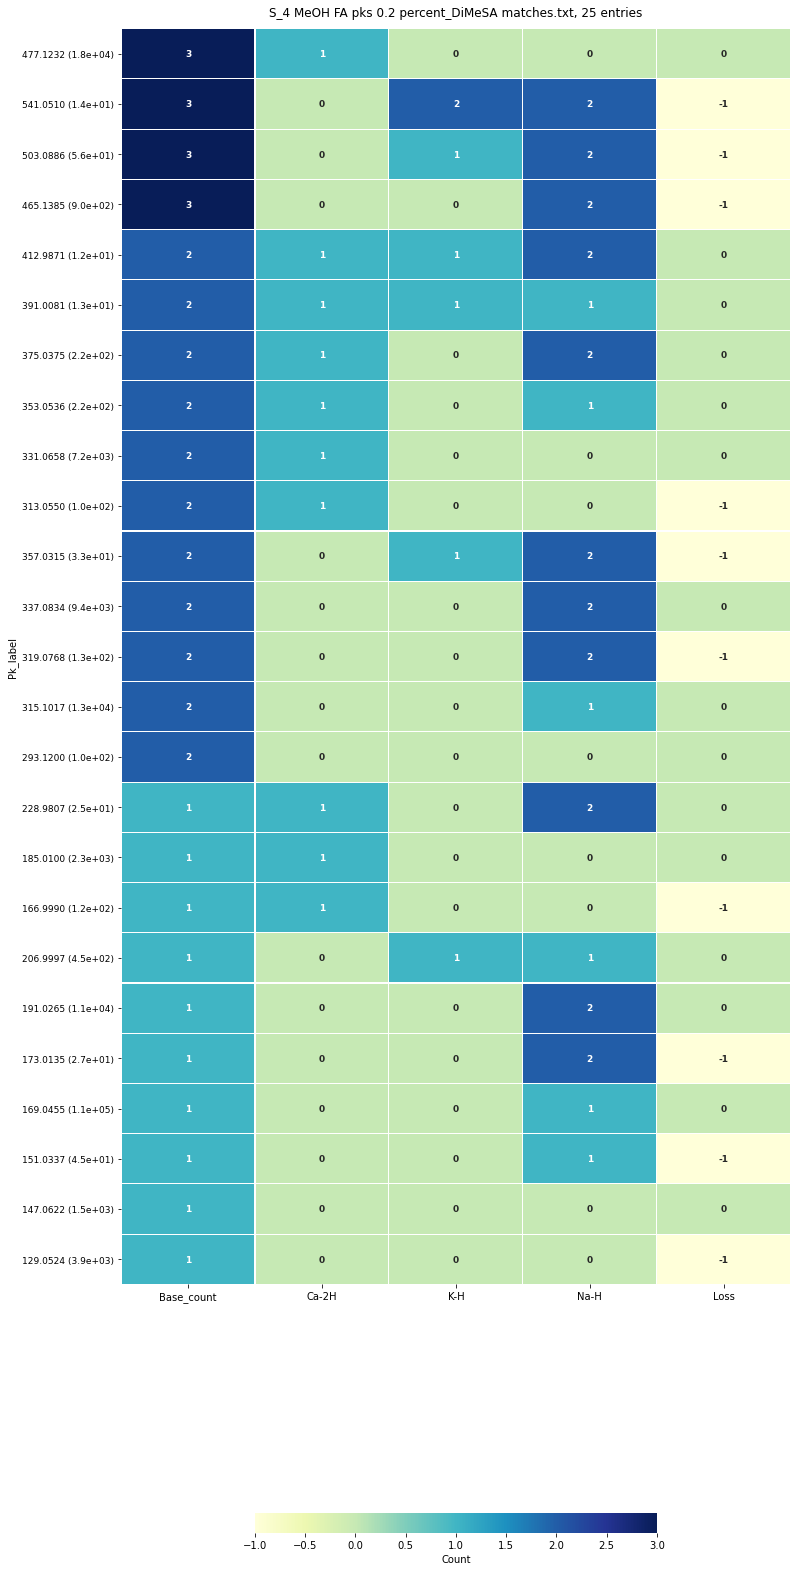

In [12]:
# Get the base count and adducts as a subset...
common_cols_in_use = [c for c in common_adducts if c in adduct_cols]

#cols_to_use = ['Pk_mass','Base_count'] + unusual_adducts + common_cols_in_use
cols_to_use = ['Pk_label','Base_count'] + unusual_adducts + common_cols_in_use

sort_order = ['Base_count'] + unusual_adducts + common_cols_in_use

if has_loss:
    sort_order = sort_order + ['Loss']     # loss will be the last filed sorted...if it exists
    cols_to_use = cols_to_use + ['Loss']
    
print(sort_order)
    
adduct_df = mono_df[cols_to_use]
adduct_df=adduct_df.set_index("Pk_label")

if has_loss:
    adduct_df['Loss'] = adduct_df['Loss'].apply(lambda x: -1 if x else 0)
    
adduct_df = adduct_df.sort_values(by = sort_order, ascending=False)   

base_counts_to_show = [] #[1,2,3,4,5]

if base_counts_to_show:
    to_plot = adduct_df[adduct_df.Base_count.isin(base_counts_to_show)]
    title_str = f'{match_file}, base counts {base_counts_to_show}, {to_plot.shape[0]} entries'
else: 
    to_plot = adduct_df
    title_str = f'{match_file}, {to_plot.shape[0]} entries'

# print(adduct_df.head())
f_size =9
#
fig, ax = plt.subplots(figsize=(12,28))         # Sample figsize in inches
g = sns.heatmap(to_plot, ax=ax, cmap="YlGnBu", annot=True, linewidths=.1, annot_kws={'fontsize':f_size, "weight": "bold"},   #or "RdPu"
           cbar_kws={'label': 'Count', 'fraction':0.025, 'shrink': 0.6, 'orientation':'horizontal'})

y_labs = g.get_yticklabels()
g.set_yticklabels(y_labs, size = f_size);
g.set_title(title_str,y=1.005)

In [13]:
# cols_to_use = ['Pk_label','Base_count'] + unusual_adducts + common_cols_in_use

# sort_order = ['Base_count'] + unusual_adducts + common_cols_in_use

grouping_cols = unusual_adducts + common_cols_in_use

print(grouping_cols)

['Ca-2H', 'K-H', 'Na-H']


In [16]:
# Use pivot table...easy to re-arrange
thresh = 10

subset = mono_df[(mono_df.Pk_inten > thresh)]

title_str = f'{match_file}, inten > {thresh}, {subset.shape[0]}/{mono_df.shape[0]} entries, bpi {base_inten:.1f}'

cols = ['K-H', 'Ca-2H']
inx = ['Base_count','Na-H']

show_rel = True
if show_rel:
    value_cols = ['Rel_inten']    #['Pk_inten']
    val_fmt_string = '{0:.4f}'    # displayed value format - use '{0:.0f}' for inetn, '{0:.4f}' for rel_inten
else:
    value_cols = ['Pk_inten']    #['Pk_inten']
    val_fmt_string = '{0:.0f}'    # displayed value format - use '{0:.0f}' for inetn, '{0:.4f}' for rel_inten
# cols = ['Na-H']
# inx = ['Base_count']


# fill_value = 0 - will replace NaNs with 0, but it's nicer to leave them and use the format statement to change them to '-' with; , na_rep="-")
pd.pivot_table(subset, index=inx, values=value_cols, columns=cols, aggfunc=np.max)  \
            .style  \
            .set_properties(**{'color':'black', 'border':'1px solid black'})  \
            .set_table_styles([{'selector' : 'th', 'props' : [('border', '1px solid black')]}])  \
            .format(val_fmt_string, na_rep="-")       \
            .background_gradient(cmap='YlGn', low=0.2, axis=None)   \
            .highlight_null('white')  \
            .set_caption(title_str)
  

In [17]:
# By mass
pd.pivot_table(subset, index=inx, values=['Pk_mass'], columns=cols, aggfunc=lambda x: min(x)) \
            .style  \
            .set_properties(**{'color':'black', 'border':'1px solid black'})  \
            .set_table_styles([{'selector' : 'th', 'props' : [('border', '1px solid black')]}])  \
            .format('{0:.3f}', na_rep="-")       \
            .highlight_null('white')  \
            .set_caption(title_str)
  